# About this notebook (LB Score : 0.546 )
 ### pytorch BERTの初心者部屋です。English version is here. https://www.kaggle.com/chumajin/pytorch-bert-beginner-s-room
 
 
 ### スコアを目指すよりも、以下のことを目的としています。
 
*   理解を深める。
*   言語処理でも数字のニューラルネットワークと同じように処理する。
        
       pytorchのニューラルネットワーク組んだことない方はまずはこちらをお勧めします。
       
       https://www.kaggle.com/chumajin/pytorch-neural-network-starter-detail
       
       

      
        


*   BERTの雛形を作成する。
  

  ### 少しでもお役に立てれば幸いです。upvoteよろしくお願いいたします !
  ### あと、いつもupvoteしていただける方ありがとうございます。
  
  
  -----ご参考--------------------------------------------------
  ### inference onlyのnotebookはこちらです。ver 7の結果（これより少し良いスコア)をuploadしております。
  ### (ver8まではこのnotebookではtrainも入るため、submitに時間がかかりすぎてsubmit errorが起こっていました)

inference onlyのnotebookはこちら　　https://www.kaggle.com/chumajin/inference-for-pytorch-bert-beginner-s-room?scriptVersionId=62477318

inference onlyにするのは、submitが早いのと、internet onにしてしまった場合にsubmitできます。

--------とは言っても、ある程度スコア出ないと公開できなかったので、以下工夫した点のメモです --------

  (初心者用と言っているくせにマニアック。後ほど解説します。)
* BertModelを使用するよりも、BertForSequenceClassificationを使用した方が私はスコアが出たので、それを採用しました。
* Bertのfine-tuningの不安定性について、 https://ai-scholar.tech/articles/bert/bert-fine-tuning を参考にパラメータをある程度採用しました。
     
    ※　Large-modelで20 epoch,5 k-foldsは時間かかるので、そこだけ、base uncased model採用しました。

##### epoch数をdebug = Falseだと20 epoch, Trueだと1にしています。流れだけ知りたい方はTrueにしてください。

In [ ]:
debug = False

#### ver9以降、inference onlyのnotebookを使用せずに、このnotebookだけでsubmitする場合は、以下のdebug2をfalseにしてください。何個かのコードを省いています。

In [ ]:
debug2 = False

# 0. 下準備

In [ ]:
import numpy as np 
import pandas as pd 
import os
       
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt 

import transformers
import random


import warnings
warnings.simplefilter('ignore')

scaler = torch.cuda.amp.GradScaler() # GPUでの高速化。

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cpuがgpuかを自動判断
device

#### ランダムシードの固定

In [ ]:
SEED = 508

def random_seed(SEED):
    
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

random_seed(SEED)

# 1. このコンペのEDA

In [ ]:
train = pd.read_csv("../input/commonlitreadabilityprize/train.csv")
train.head(3)

In [ ]:
# excerptの0番目の文章例
train.excerpt[0]

#### excerptの文章の読みやすさの難易度みたいのが、targetに記入されていて、それを予測するコンペ(とてもシンプル)

In [ ]:
test = pd.read_csv("../input/commonlitreadabilityprize/test.csv")
test

#### testにはtargetとstandard errorがない

In [ ]:
sample = pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")
sample

#### testデータのtargetを予測してsubmissionファイルとして提出。

# 2. BERT : Tokenizer の理解を深める
##      英単語をid化したりいろいろしてくれるやつ

#### bertのモデルはいろいろあるが、今回は、bert-base-uncasedを使用。
#### bert-large-uncasedとかもあるが、BERTの中の埋め込みベクトルの次元数などが違う。
#### https://www.kaggle.com/xhlulu/huggingface-bert にbert-large-uncasedは落ちているので、inputをそこに変えてもらえれば使えます。

In [ ]:
# kaggle offline mode : submitはinternetがofflineなので、offlineになっています。公開されているdatasetからもってきます。
tokenizer = transformers.BertTokenizer.from_pretrained("../input/bert-base-uncased")

# local PCなどonlineで使用する場合はこちらを使用してください。
# tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")


#### id 0番のものをtokenizerを使って、いろいろいじってみます。

In [ ]:
test_s = train["excerpt"].iloc[0]
test_s

#### 何も考えずに、tokenizerのencode_plusに食わせた場合

In [ ]:
result1 = tokenizer.encode_plus(test_s)
result1

Tokenizerのoutputとしては辞書型で出てきて、以下の3つがある
* input_ids : 単語id (BERTのpretrained modelに入っているやつ)※　細かいことを言うと、初めと終わりに、101[CLS]と102[SEP]が追加されている
* token_type_ids : 文章を把握するバイナリーマスク : 今回は回帰問題で、全部 0。文章間の繋がりを見るときは途中に[SEP]など挟んで変更したりする。
* attention_mask : 埋め込みを判定するバイナリーマスク : 例えば、今回は、後ほど文字数を合わせるために[PAD]というのを代入するが、それを判定する。
この方など見ていただけるとわかるかもです。https://qiita.com/omiita/items/72998858efc19a368e50

#### input_idsの単語idから文章に戻してみる。

In [ ]:
tokenizer.decode(result1["input_ids"])

#### 初めを表す[CLS]と終わりを表す[SEP]が追加されていることがわかる。
#### これら2つをSpecial tokensと呼んでいる(tokenizerの引数に入れるか入れないかの選択肢があるdefaultは入るようになっている)

## 【重要】BERTでは、それぞれの文章での単語数をそろえてあげる必要があります。
   ## (pretrained modelのMaxは512個)

#### まずは、今回のtrainデータで一番長い文章の単語数を数えてみます。少し時間かかります。

#### ver10以降、このtrain & inferenceのnotebookでsubmitする場合、省略しています（submitの時間超過でerror出たため)。

#### 流したい場合はdebug2=Trueにしてください。結果はプリントスクリーンして貼ってあります。

In [ ]:
if debug2:
    sen_length = []

    for sentence in tqdm(train["excerpt"]):

        token_words = tokenizer.encode_plus(sentence)["input_ids"]
        sen_length.append(len(token_words))

    print('maxlenth of all sentences are  ', max(sen_length))

#### もし、debug2をTrueにした場合、以下の結果が得られます。

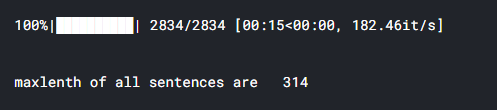

#### 314 wordsが今回のtrainデータのmax単語数。ただし、[CLS]と[SEP]を含む。

#### 314個に満たない文章は[PAD]で埋めてあげる必要がある。

In [ ]:
test_s

In [ ]:
len(test_s.split(" "))

#### tokenizerの引数を調整してあげると自動に調整してくれる

In [ ]:
result2 = tokenizer.encode_plus(
    test_s,
    add_special_tokens = True, # [CLS],[SEP]を入れるか
    max_length = 314, # paddingとtrancation(切り出し)を使って、単語数をそろえる
    pad_to_max_length = True, # ブランク箇所に[PAD]を入れる
    
    truncation = True # 切り出し機能。例えばmax_length10とかにすると、最初の10文字だけにしてくれる機能。入れないと怒られたので、入れておく
)

In [ ]:
result2

#### input_idsの102のあとに0が大量に追加。attention_maskにも、先ほどは全部1だったが、0が追加されている。

#### 単語idから文章に戻してみる

In [ ]:
tokenizer.decode(result2["input_ids"])

#### 文章の長さをそろえるために、[PAD]が追加されていることがわかる。
#### この部分は、Attention maskで0にして、計算されないようになっている。

#### 文章を短くする場合 (計算時間とかかかるとこの辺を調整することもある。例えば10にしてみる。他のnotebookだと256とかにしている人もいます。)

In [ ]:
result3 = tokenizer.encode_plus(
    test_s,
    add_special_tokens = True, # [CLS],[SEP]を入れるか
    max_length = 10, # paddingとtrancation(切り出し)を使って、単語数をそろえる
    pad_to_max_length = True, # ブランク箇所に[PAD]を入れる
    
    truncation = True # 切り出し機能。例えばmax_length10とかにすると、最初の10文字だけにしてくれる機能。入れないと怒られたので、入れておく
)

In [ ]:
result3

#### このまま使用してOK

#### 今回は、最大長の314を使用していく。(以下、Dataset内で変換)

In [ ]:
max_sens = 314

# 3. Pytorch neural networkの下準備
## 3.1 k-fold

https://www.kaggle.com/abhishek/step-1-create-folds


この方が作り方共有してくれていますが、ここではシンプルにtarget順に並び替えて、5個のfoldに順番でわけます。

In [ ]:
train = train.sort_values("target").reset_index(drop=True)
train

In [ ]:
train["kfold"] = train.index % 5

In [ ]:
train

#### まずは、お試しで、kfold = 0をvalidation, それ以外をtrainデータとします。reset_index()しないとはまりますので、注意。

In [ ]:
p_train = train[train["kfold"]!=0].reset_index(drop=True)
p_valid = train[train["kfold"]==0].reset_index(drop=True)

## 3.2 DataSet, DataLoaderを組んでいく(数字のNeural networkと同じ)

In [ ]:
class BERTDataSet(Dataset):
    
    def __init__(self,sentences,targets):
        
        self.sentences = sentences
        self.targets = targets
        
    def __len__(self):
        
        return len(self.sentences)
    
    def __getitem__(self,idx):
        
        sentence = self.sentences[idx]
        
        bert_sens = tokenizer.encode_plus(
                                sentence,
                                add_special_tokens = True, 
                                max_length = max_sens, # 上で314に設定しています
                                pad_to_max_length = True, 
                                return_attention_mask = True)

        ids = torch.tensor(bert_sens['input_ids'], dtype=torch.long)
        mask = torch.tensor(bert_sens['attention_mask'], dtype=torch.long)
        token_type_ids = torch.tensor(bert_sens['token_type_ids'], dtype=torch.long)
     
            
        target = torch.tensor(self.targets[idx],dtype=torch.float)
        
        return {
                'ids': ids,
                'mask': mask,
                'token_type_ids': token_type_ids,
                'targets': target
            }

In [ ]:
train_dataset = BERTDataSet(p_train["excerpt"],p_train["target"])
valid_dataset = BERTDataSet(p_valid["excerpt"],p_valid["target"])

In [ ]:
train_dataset[0]

#### きちんとできていることを確認

In [ ]:
train_batch = 16
valid_batch = 32

#### dataloaderの作り方(pin_memoryとかnum_worker、後ででてくるAMPも)はここの方がわかりやすく解説してくれている。

https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587


In [ ]:
train_dataloader = DataLoader(train_dataset,batch_size=train_batch,shuffle = True,num_workers=8,pin_memory=True)
valid_dataloader = DataLoader(valid_dataset,batch_size=valid_batch,shuffle = False,num_workers=8,pin_memory=True)

In [ ]:
for a in train_dataloader:
    print(a)
    break

#### きちんとできていることを確認

# 4. BERTのモデル作成

#### BERTは用途に応じて様々なpretrainedモデルがある

* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* BertForSequenceClassification
* BertForMultipleChoice
* BertForTokenClassification
* BertForQuestionAnswering

このページの方が解説してくれています。

https://kento1109.hatenablog.com/entry/2019/08/20/161936

よく出てくるのは、文章の一部を隠して、予測したり、文章間に繋がりがあるかの判定などです。


今回は、BertForSequenceClassification　を使用します。

※　最初BertModelを使っていじくっていましたが、scoreが私は上げれませんでした。。。
defaultでは、0,1のように2分類ように出力が2つになっていますが、今回は回帰問題ですので、出力(num_label)を1にしてあげます。
分類問題をしたい方はここを調整すればよいかと。

In [ ]:
model = transformers.BertForSequenceClassification.from_pretrained("../input/bert-base-uncased",num_labels=1)

In [ ]:
model.to(device)
model.train()

### modelの入力はtokenizerで出力された(単語id(input_ids)、attention_mask(mask))
token_type_idはこの場合、入れても入れなくてもOKみたいです。

outputの中身を見てみる

In [ ]:
for a in train_dataloader:
    ids = a["ids"].to(device)
    mask = a["mask"].to(device)
    #tokentype = a["token_type_ids"].to(device)
    
    output = model(ids,mask)
    break

In [ ]:
output

#### きちんと推測値が出てきている。使いたいところはlogitsのところ

In [ ]:
output["logits"]

In [ ]:
output["logits"].shape

#### shape見ると、1が余計なので、squeezeというのを使うと、1のところをcutしてくれます

In [ ]:
output["logits"].squeeze(-1)

In [ ]:
output["logits"].squeeze(-1).shape

#### なので、outputはこの形で使います。

In [ ]:
output = output["logits"].squeeze(-1).shape

# 5. trainingをする関数作成

#### optimizerの定義
* 今回、いろいろお試ししていて、学習率の重要さを学びました(最初、学習率が高すぎて、回帰して予測した結果が全部同じ値になったり、1日以上はまりました・・・。)

* とりあえず、このnotebookは、Bertのfine-tuningの不安定性について、 https://ai-scholar.tech/articles/bert/bert-fine-tuning を参考にパラメータをある程度採用しました。

* ただし、上記文献では、bert-large-uncased　での話です。今回は、5 k-fold 20epoch回すのに、時間がかかりすぎてしまったため、bert-base-uncasedにしています。

* 細かいので、とりあえず使いたいという人は無視してそのまま流してOKです。

In [ ]:
from transformers import AdamW
LR=2e-5
optimizer = AdamW(model.parameters(), LR,betas=(0.9, 0.999), weight_decay=1e-2) 

#### 以下は、transformerに内蔵された学習率のスケジューラー(stepするごとに学習率を変えていく)です。
#### ↑のサイトの推奨では、20 epochで、最初の10%で、目的の学習率に到達させた後、0になるように減衰していくモデルを言っていたので、それを作りました。

In [ ]:
from transformers import get_linear_schedule_with_warmup


epochs = 20

if debug:
    epochs = 1

train_steps = int(len(p_train)/train_batch*epochs)
print(train_steps)

num_steps = int(train_steps*0.1)

scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

#### 少し時間がかかりますが、学習率の推移をイテレーションごとに見ていくとこんな感じです。
#### ver9以降、submit時間超過対策で、実行しないようになっています。結果はプリントスクリーンで貼ってあります。

In [ ]:
if debug2:



    le=[]
    train_dataloader = DataLoader(train_dataset,batch_size=train_batch,shuffle = True,num_workers=8,pin_memory=True)

    for b in tqdm(range(epochs)):

        for a in train_dataloader:
            le.append(scheduler.get_last_lr())
            scheduler.step()

    x = np.arange(len(le))
    plt.plot(x,le)

#### 参考までに、上記をdebug2=Trueにして実行すると以下のグラフが得られます。横軸がイテレーションの回数、縦軸が学習率です。
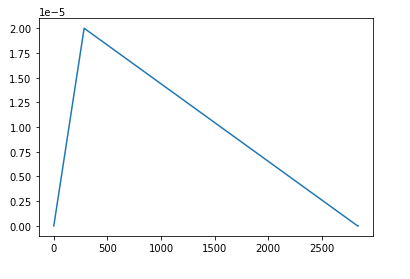

#### loss関数は、今回はRMSEなので、以下のように定義しました。

In [ ]:
def loss_fn(output,target):
    return torch.sqrt(nn.MSELoss()(output,target))

#### 以上のoptimizerとかlossを入れてtrainingを関数化。
#### AMDのautocast()を使用するので、その書き方にしています。


https://qiita.com/Sosuke115/items/40265e6aaf2e414e2fea

イメージはこちらの方がしやすいか

https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587

In [ ]:
def training(
    train_dataloader,
    model,
    optimizer,
    scheduler
):
    
    model.train()
    torch.backends.cudnn.benchmark = True

    allpreds = []
    alltargets = []

    for a in train_dataloader:

        losses = []

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():

            ids = a["ids"].to(device,non_blocking=True) # non_blocking=TrueでPinned MemoryからGPUに転送中もCPUが動作できるらしい。
            mask = a["mask"].to(device,non_blocking=True)
            tokentype = a["token_type_ids"].to(device,non_blocking=True)

            output = model(ids,mask)
            output = output["logits"].squeeze(-1)

            target = a["targets"].to(device,non_blocking=True)

            loss = loss_fn(output,target)


            # スコア習得用
            losses.append(loss.item())
            allpreds.append(output.detach().cpu().numpy())
            alltargets.append(target.detach().squeeze(-1).cpu().numpy())

        scaler.scale(loss).backward() # ロスのバックワード
        scaler.step(optimizer) # オプティマイザーの更新
        scaler.update() # スケーラーの更新
        
        del loss # ここでlossを消した方がGPUのメモリの無駄な部分を消せるらしい。https://tma15.github.io/blog/2020/08/22/pytorch%E4%B8%8D%E8%A6%81%E3%81%AB%E3%81%AA%E3%81%A3%E3%81%9F%E8%A8%88%E7%AE%97%E3%82%B0%E3%83%A9%E3%83%95%E3%82%92%E5%89%8A%E9%99%A4%E3%81%97%E3%81%A6%E3%83%A1%E3%83%A2%E3%83%AA%E3%82%92%E7%AF%80%E7%B4%84/

        scheduler.step() # 学習率の更新

        # データローダーの合併

    allpreds = np.concatenate(allpreds)
    alltargets = np.concatenate(alltargets)

    # ロス関数はモニター用だけど、一応保管

    losses = np.mean(losses)

    # Score with rmse
    train_rme_loss = np.sqrt(mean_squared_error(alltargets,allpreds))

    return losses,train_rme_loss

# 1epochテスト(実行したかったら、debug2=Trueにしてください)

In [ ]:
if debug2:
    train_dataloader = DataLoader(train_dataset,batch_size=train_batch,shuffle = True,num_workers=4,pin_memory=True)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

    losses,train_rme_loss = training(train_dataloader,model,optimizer,scheduler)
    
    print(losses,train_rme_loss)

# validationも作成します。

In [ ]:
def validating(
    valid_dataloader,
    model
):
    
    model.eval()

    allpreds = []
    alltargets = []

    for a in valid_dataloader:

        losses = []

        with torch.no_grad():

            ids = a["ids"].to(device)
            mask = a["mask"].to(device)
            tokentype = a["token_type_ids"].to(device)

            output = model(ids,mask)
            output = output["logits"].squeeze(-1)

            target = a["targets"].to(device)

            loss = loss_fn(output,target)


            # 採点用に
            losses.append(loss.item())
            allpreds.append(output.detach().cpu().numpy())
            alltargets.append(target.detach().squeeze(-1).cpu().numpy())
            
            del loss


    # dataloader分を結合

    allpreds = np.concatenate(allpreds)
    alltargets = np.concatenate(alltargets)

    # lossは使わないけど一応回収

    losses = np.mean(losses)

    # rmseでスコア出し
    valid_rme_loss = np.sqrt(mean_squared_error(alltargets,allpreds))

    return allpreds,losses,valid_rme_loss

In [ ]:
if debug2:
    allpreds,losses,valid_rme_loss = validating(valid_dataloader,model)
    print(allpreds[:3])
    print(losses)
    print(valid_rme_loss)

----version 10 追加-----


version 7はtrain & inferenceで時間超過でsubmitできませんでした。しかし、inference onlyでsubmitしたところ、0.528とスコアが出ました。


version 9はtrain & inferenceは時間超過対策で一部コードを実行しませんでした。そうすると、スコアが0.546と下がってしまいました。


この現象に関する考察は、新しいnotebookで行う予定です。（リリースしたら、コメント欄に書きます）


以下は、そこからわかったことです。いろいろとつじつまを合わせ、train & inferenceでもversion7の0.528スコアにそろえるためのコードです。

（コードの中身とか、細かいことは気にしなくても良いですが、スコアの違いが気になる方は考察用の新しいnotebookをご参照ください)

In [ ]:
if debug2 == False:
    for a in range(epochs):
        for b in train_dataloader:
            break

    losses,train_rme_loss = training(train_dataloader,model,optimizer,scheduler)

    for a in valid_dataloader:
        break

# 6. traing実施

### 解説用にいろいろやってきたので、parameterを初期化します。

In [ ]:
# initializing the data

p_train = train[train["kfold"]!=0].reset_index(drop=True)
p_valid = train[train["kfold"]==0].reset_index(drop=True)


train_dataset = BERTDataSet(p_train["excerpt"],p_train["target"])
valid_dataset = BERTDataSet(p_valid["excerpt"],p_valid["target"])

train_dataloader = DataLoader(train_dataset,batch_size=train_batch,shuffle = True,num_workers=4,pin_memory=True)
valid_dataloader = DataLoader(valid_dataset,batch_size=valid_batch,shuffle = False,num_workers=4,pin_memory=True)

model = transformers.BertForSequenceClassification.from_pretrained("../input/bert-base-uncased",num_labels=1)

model.to(device)
LR=2e-5
optimizer = AdamW(model.parameters(), LR,betas=(0.9, 0.999), weight_decay=1e-2) # AdamW optimizer

train_steps = int(len(p_train)/train_batch*epochs)

num_steps = int(train_steps*0.1)

scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

In [ ]:
trainlosses = []
vallosses = []
bestscore = None

trainscores = []
validscores = []

for epoch in tqdm(range(epochs)):
    
    print("---------------" + str(epoch) + "start-------------")
    
    trainloss,trainscore = training(train_dataloader,model,optimizer,scheduler)
    
    trainlosses.append(trainloss)
    trainscores.append(trainscore)
    
    print("trainscore is " + str(trainscore))
    
    preds,validloss,valscore=validating(valid_dataloader,model)
    
    vallosses.append(validloss)
    validscores.append(valscore)

    
    print("valscore is " + str(valscore))
    
    if bestscore is None:
        bestscore = valscore
        
        print("Save first model")
        
        state = {
                        'state_dict': model.state_dict(),
                        'optimizer_dict': optimizer.state_dict(),
                        "bestscore":bestscore
                    }
            

        torch.save(state, "model0.pth")
        
    elif bestscore > valscore:
        
        bestscore = valscore
        
        print("found better point")
        
        state = {
                        'state_dict': model.state_dict(),
                        'optimizer_dict': optimizer.state_dict(),
                        "bestscore":bestscore
                    }
            

        torch.save(state, "model0.pth")
        
    else:
        pass
    

In [ ]:
plt.scatter(p_valid["target"],preds)

In [ ]:
x = np.arange(epochs)
plt.plot(x,trainlosses)
plt.plot(x,vallosses)

In [ ]:
x = np.arange(epochs)
plt.plot(x,trainscores)
plt.plot(x,validscores)

In [ ]:
# 他のk-fold用
bestscores = []
bestscores.append(bestscore)

# 7. 他のK-foldを回していきます。

In [ ]:
for fold in range(1,5):
    

    # initializing the data

    p_train = train[train["kfold"]!=fold].reset_index(drop=True)
    p_valid = train[train["kfold"]==fold].reset_index(drop=True)


    train_dataset = BERTDataSet(p_train["excerpt"],p_train["target"])
    valid_dataset = BERTDataSet(p_valid["excerpt"],p_valid["target"])

    train_dataloader = DataLoader(train_dataset,batch_size=train_batch,shuffle = True,num_workers=4,pin_memory=True)
    valid_dataloader = DataLoader(valid_dataset,batch_size=valid_batch,shuffle = False,num_workers=4,pin_memory=True)

    model = transformers.BertForSequenceClassification.from_pretrained("../input/bert-base-uncased",num_labels=1)

    model.to(device)
    LR=2e-5
    optimizer = AdamW(model.parameters(), LR,betas=(0.9, 0.999), weight_decay=1e-2) # AdamW optimizer

    train_steps = int(len(p_train)/train_batch*epochs)

    num_steps = int(train_steps*0.1)

    scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)


    trainlosses = []
    vallosses = []
    bestscore = None

    trainscores = []
    validscores = []

    for epoch in tqdm(range(epochs)):

        print("---------------" + str(epoch) + "start-------------")

        trainloss,trainscore = training(train_dataloader,model,optimizer,scheduler)

        trainlosses.append(trainloss)
        trainscores.append(trainscore)

        print("trainscore is " + str(trainscore))

        preds,validloss,valscore=validating(valid_dataloader,model)

        vallosses.append(validloss)
        validscores.append(valscore)


        print("valscore is " + str(valscore))

        if bestscore is None:
            bestscore = valscore

            print("Save first model")

            state = {
                            'state_dict': model.state_dict(),
                            'optimizer_dict': optimizer.state_dict(),
                            "bestscore":bestscore
                        }


            torch.save(state, "model" + str(fold) + ".pth")

        elif bestscore > valscore:

            bestscore = valscore

            print("found better point")

            state = {
                            'state_dict': model.state_dict(),
                            'optimizer_dict': optimizer.state_dict(),
                            "bestscore":bestscore
                        }


            torch.save(state, "model"+ str(fold) + ".pth")

        else:
            pass


    bestscores.append(bestscore)

In [ ]:
bestscores

In [ ]:
np.mean(bestscores)
print("my cv is " + str(np.mean(bestscores)))

# 8. inference

#### 以下のinference only bookにver 7の結果をuploadしております(ver8まではこのnotebookではtrainも入るため、submitに時間がかかりすぎてsubmit errorが起こっていました)。

#### inferenceはこちら　https://www.kaggle.com/chumajin/inference-for-pytorch-bert-beginner-s-room?scriptVersionId=62477318

#### inference版はこれよりsubmitがかなり早いです。

In [ ]:
import gc
del train_dataset,valid_dataset,train_dataloader,valid_dataloader,model,optimizer,scheduler
_ = gc.collect()

In [ ]:
test

#### inferenceにtargetはないので、無し版でDatasetを作ります。

In [ ]:
class BERTinfDataSet(Dataset):
    
    def __init__(self,sentences):
        
        self.sentences = sentences
       
        
    def __len__(self):
        
        return len(self.sentences)
    
    def __getitem__(self,idx):
        
        sentence = self.sentences[idx]
        
        
        bert_sens = tokenizer.encode_plus(
                                sentence,
                                add_special_tokens = True, # [CLS],[SEP]
                                max_length = 314,
                                pad_to_max_length = True, # add padding to blank
                                truncation=True)

        ids = torch.tensor(bert_sens['input_ids'], dtype=torch.long)
        mask = torch.tensor(bert_sens['attention_mask'], dtype=torch.long)
        token_type_ids = torch.tensor(bert_sens['token_type_ids'], dtype=torch.long)
     
        
    
        
        return {
                'ids': ids,
                'mask': mask,
                'token_type_ids': token_type_ids,
                
            }

In [ ]:
test_dataset = BERTinfDataSet(test["excerpt"])

In [ ]:
test_batch = 32

In [ ]:
test_dataloader = DataLoader(test_dataset,batch_size=test_batch,shuffle = False,num_workers=4,pin_memory=True)

In [ ]:
model = transformers.BertForSequenceClassification.from_pretrained('../input/bert-base-uncased',num_labels=1)

### 作成したモデルをロードします。

In [ ]:
pthes = [os.path.join("./",s) for s in os.listdir("./") if ".pth" in s]
pthes

#### 推論する関数を作成します。

In [ ]:
def predicting(
    test_dataloader,
    model,
    pthes
    
):

    allpreds = []
    
    for pth in pthes:
        
        state = torch.load(pth)
        
        model.load_state_dict(state["state_dict"])
        model.to(device)
        model.eval()
    
    
        preds = []
        allvalloss=0

        with torch.no_grad():


            for a in test_dataloader:



                ids = a["ids"].to(device)
                mask = a["mask"].to(device)
                tokentype = a["token_type_ids"].to(device)

               # output = model(ids,mask,tokentype)
                output = model(ids,mask)

                output = output["logits"].squeeze(-1)


                preds.append(output.cpu().numpy())

            preds = np.concatenate(preds)
            
            allpreds.append(preds)

    return allpreds


In [ ]:
allpreds = predicting(test_dataloader,model,pthes)

#### 5個のモデルの結果を平均します。

In [ ]:
findf = pd.DataFrame(allpreds)
findf = findf.T

In [ ]:
findf

In [ ]:
finpred = findf.mean(axis=1)
finpred

In [ ]:
sample

In [ ]:
sample["target"] = finpred

In [ ]:
sample

In [ ]:
sample.to_csv("submission.csv",index = False)

# ここまで見て頂き、ありがとうございます！

# お役に立ちましたら、upvoteしていただけると嬉しいです。
## また、各参考urlの方々には、たくさんのことを学びました。大変ありがとうございました！

(途中でも紹介していますが) 

 ### 以下のinference only bookにver 7の結果（これより少し良いスコア)をuploadしております。
 ### (ver8まではこのnotebookではtrainも入るため、submitに時間がかかりすぎてsubmit errorが起こっていました)

inference onlyのnotebookはこちら　　https://www.kaggle.com/chumajin/inference-for-pytorch-bert-beginner-s-room?scriptVersionId=62477318

inference onlyにするのは、submitが早いのと、internet onにしてしまった場合にsubmitできます。